In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
import plotly.express as px


from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, RepeatedStratifiedKFold, cross_val_score, cross_val_predict, GridSearchCV, RandomizedSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier

## Understand Data

In [2]:
churn_data = pd.read_csv("./data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
churn_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
for column in churn_data.columns:
    print(f"{column}: {churn_data[column].nunique()}")

customerID: 7043
gender: 2
SeniorCitizen: 2
Partner: 2
Dependents: 2
tenure: 73
PhoneService: 2
MultipleLines: 3
InternetService: 3
OnlineSecurity: 3
OnlineBackup: 3
DeviceProtection: 3
TechSupport: 3
StreamingTV: 3
StreamingMovies: 3
Contract: 3
PaperlessBilling: 2
PaymentMethod: 4
MonthlyCharges: 1585
TotalCharges: 6531
Churn: 2


In [5]:
# although senior citizen is int but sems categorical given only 2 unique values
churn_data['SeniorCitizen'].unique()

array([0, 1])

- 1 means senior cetizen and 0 means no


### Removing high Cardinal column

In [6]:
# we can drop CustomerID column since it has high cardinality
churn_data.drop(['customerID'], axis=1, inplace=True)

In [7]:
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [8]:
# convert into float since total charges is numerical column
# churn_data['TotalCharges'] = churn_data['TotalCharges'].astype(float) --- Since this is giving an error because there are sting in that column

churn_data['TotalCharges'] = churn_data['TotalCharges'].replace(' ', np.nan, regex=True)
churn_data['TotalCharges'] = churn_data['TotalCharges'].astype(float)

In [9]:
churn_data.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.00,0.000,0.0000,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.00,29.000,55.0000,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.50,70.350,89.8500,118.75
TotalCharges,7032.0,2283.300441,2266.771362,18.80,401.45,1397.475,3794.7375,8684.80


<Axes: xlabel='SeniorCitizen', ylabel='count'>

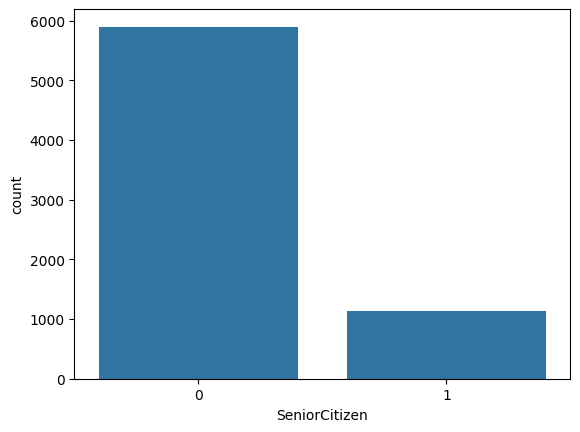

In [10]:
# there is lot more imbalance in senior citizen
sns.countplot(x = "SeniorCitizen", data = churn_data)

### Missing value treatment

In [11]:
churn_data.isnull().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [12]:
knn_imputer = KNNImputer(n_neighbors=3)
churn_data[['TotalCharges']] = knn_imputer.fit_transform(churn_data[['TotalCharges']])

In [13]:
churn_data.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

<Axes: xlabel='Churn', ylabel='count'>

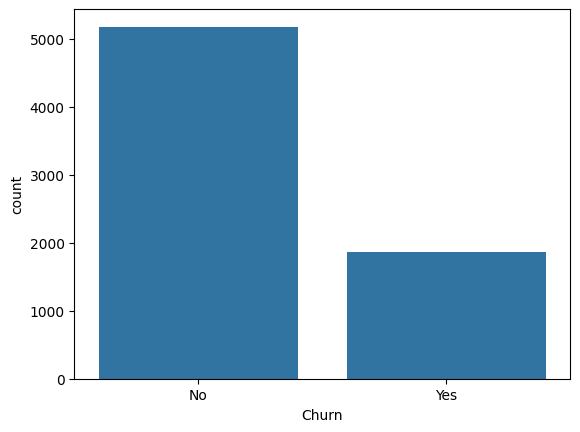

In [14]:
sns.countplot(x = "Churn", data = churn_data)

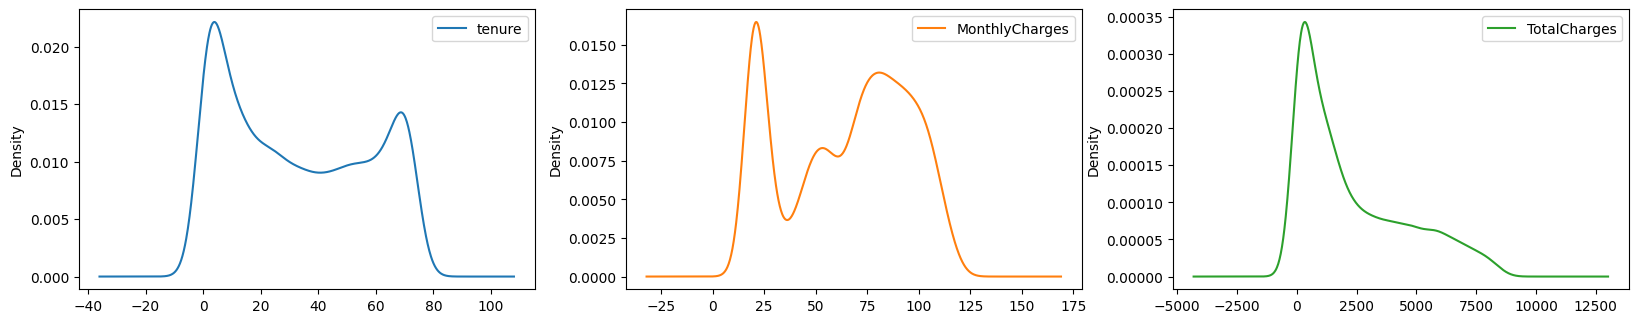

In [15]:
numeric_feature = ['tenure', 'MonthlyCharges', 'TotalCharges']
churn_data[numeric_feature].plot(kind='density', subplots=True, layout=(2,3), sharex=False, figsize= (20,8))
plt.show()

### Check for outliers

<Axes: >

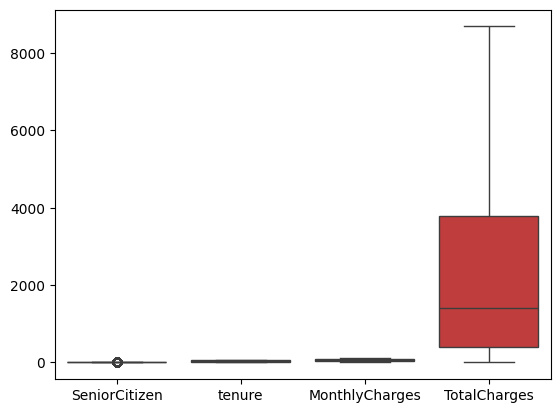

In [16]:
sns.boxplot(data=churn_data)

In [17]:
for col in numeric_feature:
    fig = px.box(churn_data, y=col, title=f"Box Plot for {col}")
    fig.show()

## Encode columns

In [18]:
categorical_features = [col for col in churn_data.columns if col not in numeric_feature]
for i in range(len(categorical_features)):
    print(f"{categorical_features[i]}: {churn_data[categorical_features[i]].unique()}")
    print()

gender: ['Female' 'Male']

SeniorCitizen: [0 1]

Partner: ['Yes' 'No']

Dependents: ['No' 'Yes']

PhoneService: ['No' 'Yes']

MultipleLines: ['No phone service' 'No' 'Yes']

InternetService: ['DSL' 'Fiber optic' 'No']

OnlineSecurity: ['No' 'Yes' 'No internet service']

OnlineBackup: ['Yes' 'No' 'No internet service']

DeviceProtection: ['No' 'Yes' 'No internet service']

TechSupport: ['No' 'Yes' 'No internet service']

StreamingTV: ['No' 'Yes' 'No internet service']

StreamingMovies: ['No' 'Yes' 'No internet service']

Contract: ['Month-to-month' 'One year' 'Two year']

PaperlessBilling: ['Yes' 'No']

PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']

Churn: ['No' 'Yes']



In [19]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
data = churn_data.copy()

one_hot_cols = ['gender', 'Contract', 'PaymentMethod']
label_cols = [col for col in categorical_features if col not in one_hot_cols+['SeniorCitizen']]



label_encoders = {}
for col in label_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

df_encoded = pd.get_dummies(data, columns=one_hot_cols, drop_first=True)

print(df_encoded.head())

   SeniorCitizen  Partner  Dependents  tenure  PhoneService  MultipleLines  \
0              0        1           0       1             0              1   
1              0        0           0      34             1              0   
2              0        0           0       2             1              0   
3              0        0           0      45             0              1   
4              0        0           0       2             1              0   

   InternetService  OnlineSecurity  OnlineBackup  DeviceProtection  ...  \
0                0               0             2                 0  ...   
1                0               2             0                 2  ...   
2                0               2             2                 0  ...   
3                0               2             0                 2  ...   
4                1               0             0                 0  ...   

   PaperlessBilling  MonthlyCharges  TotalCharges  Churn  gender_Male  \
0      

In [20]:
df_encoded.columns

Index(['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'gender_Male', 'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

## Oversampling Method

<Axes: xlabel='Churn', ylabel='count'>

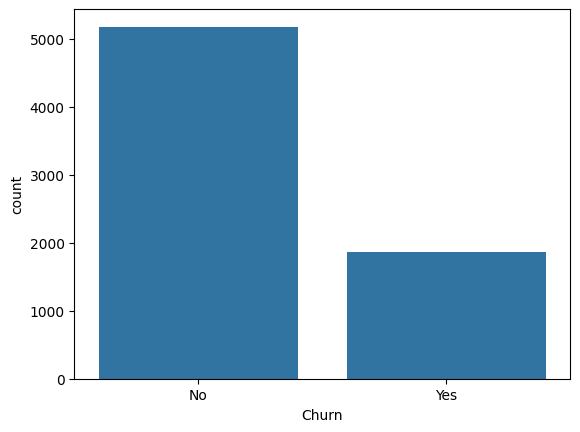

In [21]:
sns.countplot(x = "Churn", data = churn_data)

In [31]:
import pandas as pd
import numpy as np
from collections import Counter
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import Normalizer

# Sample dataset with an imbalanced target feature
df = df_encoded.copy()


X = df.drop(columns=['Churn'], axis=1)
y = df['Churn']


print("Before Oversampling:", Counter(y))

ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X, y)
print("After RandomOverSampling:", Counter(y_ros))

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)
print("After SMOTE:", Counter(y_smote))

smote_tomek = SMOTETomek(random_state=42)
X_smt, y_smt = smote_tomek.fit_resample(X, y)
print("After SMOTETomek:", Counter(y_smt))

Before Oversampling: Counter({0: 5174, 1: 1869})
After RandomOverSampling: Counter({0: 5174, 1: 5174})
After SMOTE: Counter({0: 5174, 1: 5174})
After SMOTETomek: Counter({0: 4809, 1: 4809})


In [24]:
X

0       0
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: Churn, Length: 7043, dtype: int64

In [23]:
def train_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    # Initialize Models
    models = {
        "Logistic Regression": LogisticRegression(),
        "Random Forest with Imbalance": RandomForestClassifier(n_estimators=100, class_weight='balanced',random_state=42),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    }

    # Train & Evaluate Each Model
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_train = model.predict(X_train)

        training_accuracy = accuracy_score(y_train, y_pred_train)


        print(f"\n{name} Performance:")
        print("Test Accuracy:", accuracy_score(y_test, y_pred))
        print(f"Training Accuracy: {training_accuracy}")

        print("Classification Report:\n", classification_report(y_test, y_pred))
        print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [27]:
models = {
        "Logistic Regression": LogisticRegression(),
        "Random Forest with Imbalance": RandomForestClassifier(n_estimators=100, class_weight='balanced',random_state=42),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
}

# Train & Evaluate Each Model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    training_accuracy = accuracy_score(y_train, y_pred_train)


    print(f"\n{name} Performance:")
    print("Test Accuracy:", accuracy_score(y_test, y_pred))
    print(f"Training Accuracy: {training_accuracy}")

    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

/opt/miniconda3/envs/jpm-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression




Logistic Regression Performance:
Test Accuracy: 0.8002839564600095
Training Accuracy: 0.8062880324543611
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87      1539
           1       0.67      0.53      0.59       574

    accuracy                           0.80      2113
   macro avg       0.75      0.71      0.73      2113
weighted avg       0.79      0.80      0.79      2113

Confusion Matrix:
 [[1389  150]
 [ 272  302]]

Random Forest with Imbalance Performance:
Test Accuracy: 0.7898722195929957
Training Accuracy: 0.9983772819472616
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.92      0.86      1539
           1       0.67      0.45      0.54       574

    accuracy                           0.79      2113
   macro avg       0.74      0.68      0.70      2113
weighted avg       0.78      0.79      0.78      2113

Confusion Matrix:
 [[1410  129]

In [28]:
train_data(X_ros, y_ros)

/opt/miniconda3/envs/jpm-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression




Logistic Regression Performance:
Test Accuracy: 0.7822866344605475
Training Accuracy: 0.7553499930967831
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.75      0.78      1574
           1       0.76      0.81      0.79      1531

    accuracy                           0.78      3105
   macro avg       0.78      0.78      0.78      3105
weighted avg       0.78      0.78      0.78      3105

Confusion Matrix:
 [[1184  390]
 [ 286 1245]]

Random Forest with Imbalance Performance:
Test Accuracy: 0.8904991948470209
Training Accuracy: 0.9984812922822035
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.84      0.89      1574
           1       0.85      0.95      0.89      1531

    accuracy                           0.89      3105
   macro avg       0.89      0.89      0.89      3105
weighted avg       0.90      0.89      0.89      3105

Confusion Matrix:
 [[1317  257]

In [29]:
train_data(X_smote, y_smote)

/opt/miniconda3/envs/jpm-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression




Logistic Regression Performance:
Test Accuracy: 0.8090177133655394
Training Accuracy: 0.7981499378710479
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.79      0.81      1574
           1       0.80      0.82      0.81      1531

    accuracy                           0.81      3105
   macro avg       0.81      0.81      0.81      3105
weighted avg       0.81      0.81      0.81      3105

Confusion Matrix:
 [[1249  325]
 [ 268 1263]]

Random Forest with Imbalance Performance:
Test Accuracy: 0.8518518518518519
Training Accuracy: 0.998895485296148
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.86      0.85      1574
           1       0.85      0.85      0.85      1531

    accuracy                           0.85      3105
   macro avg       0.85      0.85      0.85      3105
weighted avg       0.85      0.85      0.85      3105

Confusion Matrix:
 [[1350  224]


In [30]:
train_data(X_smt, y_smt)

/opt/miniconda3/envs/jpm-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression




Logistic Regression Performance:
Test Accuracy: 0.8184338184338185
Training Accuracy: 0.8265002970885323
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.80      0.82      1447
           1       0.81      0.84      0.82      1439

    accuracy                           0.82      2886
   macro avg       0.82      0.82      0.82      2886
weighted avg       0.82      0.82      0.82      2886

Confusion Matrix:
 [[1155  292]
 [ 232 1207]]

Random Forest with Imbalance Performance:
Test Accuracy: 0.8607068607068608
Training Accuracy: 0.9989601901366607
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.85      0.86      1447
           1       0.85      0.87      0.86      1439

    accuracy                           0.86      2886
   macro avg       0.86      0.86      0.86      2886
weighted avg       0.86      0.86      0.86      2886

Confusion Matrix:
 [[1230  217]

## Handle overfitting

In [32]:
normalizer = Normalizer(norm='l2')
X_normalized = normalizer.fit_transform(X_ros)

train_data(X_normalized, y_ros)


Logistic Regression Performance:
Test Accuracy: 0.6769726247987118
Training Accuracy: 0.6736159050117355
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.85      0.73      1574
           1       0.76      0.50      0.60      1531

    accuracy                           0.68      3105
   macro avg       0.70      0.67      0.67      3105
weighted avg       0.70      0.68      0.67      3105

Confusion Matrix:
 [[1334  240]
 [ 763  768]]

Random Forest with Imbalance Performance:
Test Accuracy: 0.8927536231884058
Training Accuracy: 0.9984812922822035
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.84      0.89      1574
           1       0.85      0.95      0.90      1531

    accuracy                           0.89      3105
   macro avg       0.90      0.89      0.89      3105
weighted avg       0.90      0.89      0.89      3105

Confusion Matrix:
 [[1317  257]